# Settings

In [1]:
import re
import numpy as np
import faiss
import torch
from typing import List
from utilities.configure_script import ConfigurationLoader
from utilities.utils import read_json, read_txt
from utilities.chunk_utils import get_token_count
from sentence_transformers import SentenceTransformer
from mistral_common.tokens.tokenizers.mistral import MistralTokenizer
from PIL import Image
from mistral_common.protocol.instruct.messages import UserMessage
from mistral_common.protocol.instruct.request import ChatCompletionRequest

d:\Proyectos\Docker\Multimodal_RAG\amb_mulrimodalrag\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
import os
from dotenv import load_dotenv
from mistralai import Mistral

# Cargar variables de entorno desde el archivo .env
load_dotenv()

api_key = os.environ["MISTRAL_API_KEY"]
model = "mistral-embed"
client = Mistral(api_key=api_key)

In [3]:
configs = ConfigurationLoader.get_config()

In [4]:
tokenizer = MistralTokenizer.v3()
model_name = "open-mistral-7b"
tokenizer = MistralTokenizer.from_model(model_name)

In [5]:
data = read_json(configs['paths']['recepies_path']['recepies_chunked_json'])
loaded_embeddings = np.load(configs['paths']['recepies_path']['recepies_embeddings'])
recepies_ids = read_txt(configs['paths']['recepies_path']['recepies_doc_ids'])

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device)

In [8]:
# Inicializar FAISS y cargar los embeddings
d = loaded_embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index_with_ids = faiss.IndexIDMap(index)

index_with_ids.add_with_ids(loaded_embeddings, recepies_ids)

In [9]:
def run_mistral(user_message, model="mistral-large-latest"):
    messages = [
        {
            "role": "user", "content": user_message
        }
    ]
    chat_response = client.chat.complete(
        model=model,
        messages=messages
    )
    return (chat_response.choices[0].message.content)

In [10]:
def get_image(image_path):
    image = Image.open(image_path)
    return image

In [11]:
def get_text_embedding(input:str, device, model_name='sentence-transformers/all-MiniLM-L6-v2')->List:
    model = SentenceTransformer(model_name).to(device)
    embeddings_batch_response = model.encode(str(input))
    embeddings_batch_response = embeddings_batch_response.reshape(1, 384)
    return np.array(embeddings_batch_response)

In [12]:
def get_context(query, original_data, vector_DB, num_chunks_retieved, device,images_folder_path):
    embeddings_query = get_text_embedding(query, device)
    print(embeddings_query.shape)
    D, I = vector_DB.search(embeddings_query.astype('float32'), k=num_chunks_retieved)
    chunks_retrieved = I.tolist()[0]
    context = ''
    images_list = []
    for context_window in chunks_retrieved:
        context += original_data[context_window]['Recepie'] + '\n\n'
        images_list.append(images_folder_path + original_data[context_window]['Image'] + '.jpg') 
    _, token_count = get_token_count(context, tokenizer)
    if token_count > 4000:
        print('The context provided by the window is to large to input into LLM')
        return None, None
    else:
        print('Ok')
        return context, images_list

In [13]:
def promt_processing(query, context, images):
    prompt = f"""
    Context information is below.
    ---------------------
    {context}
    ---------------------
    {images}
    ---------------------
    Given the context information and not prior knowledge, answer the query, choose the correct image route from the directory paths 
    and write your answer in a markdown form.
    Be consistent, always write the image paths with this label **Image Path:**, and always split recepies with \n\n---\n\n
    Query: {query}
    Image path:
    Answer:
    """
    return prompt

In [14]:
def answer_processing(answer):

    image_paths = re.findall(r'\*\*Image Path:\*\*\s*`(.+?)`|```(.+?)```', answer)
    image_paths = [path[0] if path[0] else path[1] for path in image_paths]
    text_without_images = re.sub(r'\n?\*\*Image Path:\*\*\s*`(.+?)`\n?|```(.+?)```\n?', '', answer).strip()
    text_splited = text_without_images.split('\n\n---\n\n')[1:]

    for text, image in zip(text_splited,image_paths):
        display(print(text), get_image(image))

In [15]:
import re
from pathlib import Path
from IPython.display import display, Markdown
from PIL import Image

def get_image(image_path):
    try:
        # 🔥 1. Limpiar comillas simples y dobles, y reemplazar backslashes por slashes
        cleaned_path = image_path.strip().strip('"').strip("'").replace('\\\\', '/').replace('\\', '/')

        # 🔥 2. Convertir a ruta absoluta
        path = Path(cleaned_path).resolve()

        # 🔍 3. Verificar si existe
        if not path.exists():
            print(f"⚠️ Imagen no encontrada: {path}")
            return None

        return Image.open(path)

    except Exception as e:
        print(f"❌ Error al abrir la imagen: {e}")
        return None


def answer_processing(answer):
    # 1. Extraer rutas de imagen
    image_paths = re.findall(r'\*\*Image Path:\*\*\s*(?:`)?(.+?)(?:`)?(?:\n|$)', answer)

    # 2. Eliminar líneas de image path
    text_without_images = re.sub(r'\n?\*\*Image Path:\*\*\s*(?:`)?(.+?)(?:`)?(?:\n|$)', '', answer).strip()
    
    # 2.1 Eliminar imágenes embebidas tipo ![alt](ruta)
    text_cleaned = re.sub(r'!\[.*?\]\((.*?)\)', '', text_without_images)

    # 3. Dividir por receta
    text_splitted = text_cleaned.split('\n\n---\n\n')

    # 4. Mostrar texto + imagen
    for text, image_path in zip(text_splitted, image_paths):
        display(Markdown(f"### Receta"))
        display(Markdown(text.strip()))
        
        image = get_image(image_path)
        if image:
            display(image)


# Chat

In [16]:
# query = 'please give me only one modify recepie of pastries of berries but use stevia instead of regular sugar'
# query = 'give some dish with curry in it. But i want some international dish'
# query = 'give me some recepie preparation with the use of oven and lamb'
# query = 'give recepies for christmas'
# query = 'quiero una variedad de ensaladas pero sin nueces que me puedes recomendar?'
# query = 'give me some recepie preparation with the use of oven and lamb'
# query = ''
# query = 'please give me only one modify recepie of pastries of berries but use stevia instead of regular sugar'

In [17]:
query = 'give me some pork recepies'
context, images = get_context(query, data, index_with_ids, num_chunks_retieved=4, device=device, images_folder_path=configs['paths']['recepies_path']['images_folder'])
prompt = promt_processing(query=query, context=context, images=images)
answer = run_mistral(prompt)

(1, 384)
Ok


In [18]:
answer

'---\n\n### Sticky-Sweet Grilled Pork Shoulder with Hoisin and Molasses\n\n#### Ingredients:\n- 2 heads of garlic, cloves separated, peeled\n- 1 (wide, 6") piece ginger, peeled, chopped\n- 1 cup hoisin sauce\n- 3/4 cup fish sauce\n- 2/3 cup honey\n- 2/3 cup Shaoxing (Chinese rice) wine\n- 1/2 cup chili oil\n- 1/3 cup oyster sauce\n- 1/3 cup toasted sesame oil\n- 1 (4–5-lb.) skinless boneless pork shoulder (Boston butt)\n- Kosher salt\n- 3/4 cup (packed) dark brown sugar\n- 1 Tbsp. mild-flavored (light) molasses\n- Bread-and-butter pickles, white bread, cilantro, and rinsed thinly sliced white onion (for serving)\n\n#### Preparation Instructions:\n1. Purée garlic, ginger, hoisin sauce, fish sauce, honey, wine, chili oil, oyster sauce, and sesame oil in a blender until very smooth. Place 1 1/2 cups in a small bowl for glaze; cover and chill until ready to use. Pour remaining marinade into a 2-gal. resealable plastic bag.\n2. Place pork shoulder, fat side down, on a cutting board with a s

### Receta

---

### Sticky-Sweet Grilled Pork Shoulder with Hoisin and Molasses

#### Ingredients:
- 2 heads of garlic, cloves separated, peeled
- 1 (wide, 6") piece ginger, peeled, chopped
- 1 cup hoisin sauce
- 3/4 cup fish sauce
- 2/3 cup honey
- 2/3 cup Shaoxing (Chinese rice) wine
- 1/2 cup chili oil
- 1/3 cup oyster sauce
- 1/3 cup toasted sesame oil
- 1 (4–5-lb.) skinless boneless pork shoulder (Boston butt)
- Kosher salt
- 3/4 cup (packed) dark brown sugar
- 1 Tbsp. mild-flavored (light) molasses
- Bread-and-butter pickles, white bread, cilantro, and rinsed thinly sliced white onion (for serving)

#### Preparation Instructions:
1. Purée garlic, ginger, hoisin sauce, fish sauce, honey, wine, chili oil, oyster sauce, and sesame oil in a blender until very smooth. Place 1 1/2 cups in a small bowl for glaze; cover and chill until ready to use. Pour remaining marinade into a 2-gal. resealable plastic bag.
2. Place pork shoulder, fat side down, on a cutting board with a short end facing you. Holding a long sharp knife about 1"–1 1/2" above cutting board, make a shallow cut along the entire length of a long side of shoulder. Continue cutting deeper into meat, lifting and unfurling with your free hand, until it lies flat (it’s better to end up with 2–3 even pieces than 1 uneven piece). Add to bag with marinade and seal, pressing out air. Work pork around inside bag to coat with marinade. Chill at least 8 hours and up to 1 day.
3. Prepare a Big Green Egg for medium heat (with cover closed, thermometer should register 350°F). Remove pork from marinade, letting excess drip off. Lightly season all over with salt. Fit grill with convection plate and set pork on top. (If you don’t have a convection plate, bank coals on one side and set pork over cooler area to avoid flare-ups.) Cover and roast pork until an instant-read thermometer inserted into the thickest part registers 140°F–145°F. (You can also do initial cooking in a 350°F oven.) Transfer to a cutting board and let rest at least 20 minutes.
4. Bring brown sugar, molasses, and reserved marinade to a simmer in a large saucepan; cook until reduced by one-third, 6–8 minutes (you should have about 1 1/3 cups). Keep warm.
5. Prepare a Big Green Egg for medium-high heat (or use a conventional grill). Grill pork, basting and turning with 2 pairs of tongs every minute or so, until thickly coated with glaze, lightly charred in spots, and warmed through (an instant-read thermometer inserted into the thickest part should register 130°F–145°F; be careful not to overcook), 6–8 minutes. Transfer to a cutting board; slice against the grain ¼" thick. Serve with pickles, bread, cilantro, and onion.
6. Pork can be roasted 2 days ahead. Let cool; cover and chill.

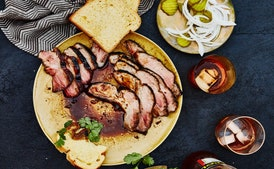

In [19]:
answer_processing(answer)

### Respuestas de prueba

## Christmas Wreaths

### Ingredients
- 1/2 cup (4 ounces) unsalted butter
- 30 (7.25 ounces) large marshmallows
- 1 1/2 teaspoons green liquid food coloring
- 1 teaspoon pure vanilla extract
- 4 cups (5 ounces) cornflakes
- 2 tablespoons (1 ounce) cinnamon red-hots (candied)
- Equipment: flat counter or cookie sheet, lined with wax paper, sprayed with nonstick vegetable cooking spray or lightly greased or buttered; 2 small spoons sprayed with nonstick vegetable cooking spray or lightly greased or buttered.

### Preparation Instructions
1. Spray a medium saucepan with nonstick vegetable shortening or lightly grease it.
2. Melt the butter over low heat.
3. Add the marshmallows and melt them over low heat, stirring constantly, until smooth (about 6 minutes). Remove the pan from the heat and whisk in the food coloring and vanilla extract until well blended. Stir in the cornflakes to coat them well.
4. Keep the mixture warm by placing the saucepan in a large pot or skillet filled with 1 in

None

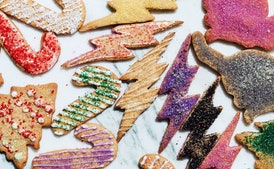

## Christmas Cake

### Ingredients
- 3 cups (450g) raisins
- 1 1⁄2 cups (240g) golden raisins
- 1 cup (160g) dried currants
- 8 soft fresh dates (160g), pitted and chopped
- 1 cup (140g) slivered almonds
- 3/4 cup (180ml) brandy
- 250g unsalted butter, softened
- 1 1/4 cups (220g) light brown sugar
- 4 eggs
- 2 1/4 cups (335g) plain (all-purpose) flour, sifted
- 1/4 teaspoon bicarbonate of (baking) soda
- 1 1/2 teaspoons ground cinnamon
- 1 teaspoon ground allspice
- 2–3 tablespoons brandy, extra

### Preparation Instructions
1. Place both raisins, currants, dates and almonds in a large bowl. Add the brandy, mix to combine and cover with plastic wrap. Allow to soak in a cool dark place overnight, mixing occasionally.
2. Preheat oven to 140°C (275°F). Line a 20cm (8-inch) square cake tin with 2 layers of non-stick baking paper.
3. Place the butter and sugar in the bowl of an electric mixer and beat on medium speed for 8 minutes or until pale and creamy. Add the eggs, 1 at a time, beatin

None

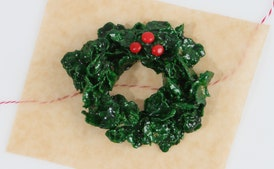

## Christmas Honey Fritters (Struffoli)

### Ingredients
- 3 1/2 cups all-purpose flour
- 5 large eggs
- 1 large egg yolk
- Grated zest of 2 lemons
- Juice of 1 lemon
- Grated zest of 1 orange
- 1/2 teaspoon salt
- 1 tablespoon limoncello or grand Marnier
- 4 cups extra-virgin olive oil, for deep-frying
- 2 cups honey
- Confectioners' sugar, for dusting

### Preparation Instructions
1. In a large bowl, combine the flour, eggs, yolk, half the lemon zest, the orange zest, salt, and limoncello. Stir with a wooden spoon to mix well, then knead into a firm dough, 8 to 10 minutes. Cover and allow to rest in the refrigerator for 30 minutes.
2. Cut the dough into golf ball-sized pieces. One at a time, roll each one into a 1/2-inch-thick rope, and cut into 1/2-inch-long pieces, and roll each piece into a ball. Place in a floured tray.
3. In a large deep pot, heat the oil to 375°F. Working in batches to avoid crowding the pan, fry the balls until dark golden brown, using a slotted spoon to turn 

None

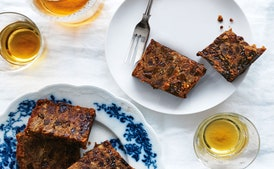

In [176]:
answer_processing(answer)

### Prawn Moilee

**List of ingredients:**
- 6 green chillies
- 55ml (about ¼ cup) vegetable oil
- 2 tsp. mustard seeds
- 30 fresh curry leaves
- 300g (2 cups) Spanish white onions, sliced (a little chunky is good)
- 15g (1 Tbsp.) garlic paste
- 15g (1 Tbsp.) ginger paste
- 2 tsp. fine sea salt
- 1 tsp. freshly ground black pepper
- 1¼ tsp. ground turmeric
- 25g (¼ cup) fresh root ginger, cut into matchsticks
- 400ml (about 2 cups) coconut milk
- 250ml (about 1 cup) coconut cream
- 24 large prawns
- 300g (about 1 ½ cups) medium tomatoes, cut into small bite-sized wedges
- Lemon wedges, to serve

**Preparation instructions:**
1. Remove and discard the stalks from the chillies, then slice each one into 3 or 4 long strips. Set to one side.
2. Place a large saucepan over a medium heat. Add 40ml of the oil, let it warm for a few seconds, then add the mustard seeds and 20 curry leaves. Let them crackle for a few seconds.
3. Add the onions and sauté lightly for 12–14 minutes, until soft but n

None

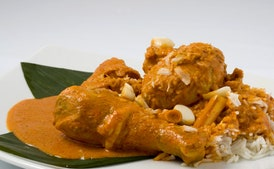

### Easy Green Curry with Chicken, Bell Pepper, and Sugar Snap Peas

**List of ingredients:**
- 1 tablespoon virgin coconut or canola oil
- 1/4 cup green curry paste
- 1 1/2 teaspoons freshly grated ginger
- 1/2 teaspoon finely grated lime zest
- 1 medium onion, sliced into 1/4-inch strips
- 1 teaspoon kosher salt
- 1 red bell pepper, sliced into 1/4-inch strips
- 1 cup homemade chicken stock or low-sodium chicken broth
- 4 cups 1/2-inch cubed cooked chicken (from 1 [2 1/2-pound] rotisserie chicken)
- 1/2 pound sugar snap peas, trimmed (about 2 1/2 cups)
- 1 (14-ounce) can coconut milk
- 1/4 cup basil leaves
- 1 tablespoon fresh lime juice
- Cooked rice or rice noodles and lime wedges (for serving)

**Preparation instructions:**
1. Heat oil in a medium pot over medium. Cook curry paste, ginger, and lime zest, stirring, until heated through, about 1 minute.
2. Add onion and salt and cook, stirring, until onion is soft, about 3 minutes.
3. Add bell pepper and stir to combine.
4. Add chic

None

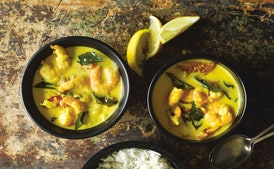

In [16]:
answer_processing(answer)

### Herb-Roasted Leg of Lamb with Vegetables and Jus

**List of Ingredients:**
- 4 medium onions, peeled (roots trimmed but still attached) and quartered
- 1 large stalk celery, quartered
- 6 large garlic cloves, lightly crushed and peeled
- 4 tablespoons extra-virgin olive oil
- 1 (7-pound) boneless leg of lamb, trimmed, rolled, and tied
- 1 teaspoon herbes de Provence
- 1 1/2 teaspoons kosher salt
- 1/2 teaspoon freshly ground black pepper
- 6 medium carrots, peeled and cut into 3-inch-long pieces
- 2 medium or 1 large celery root, peeled and cut into 1 1/2-inch chunks
- 1 1/2 cups dry white wine
- 1 1/2 cups low-sodium beef broth or chicken broth

**Preparation Instructions:**
1. Preheat oven to 400°F.
2. In roasting pan, combine onions, celery, and garlic cloves. Drizzle with 1 tablespoon oil, toss well to coat, and mound in center of pan. Set lamb atop mixture.
3. Drizzle with 1 tablespoon oil and sprinkle with herbes de Provence, salt, and pepper. Arrange carrots and celery root 

None

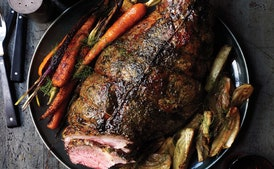

### Roast Lamb with Marionberry-Pecan Crust

**List of Ingredients:**
- 2 well-trimmed racks of lamb (each about 1 1/4 pounds)
- 6 tablespoons marionberry or boysenberry jam
- 1/4 cup Dijon mustard
- 3/4 cup finely chopped pecans
- 6 tablespoons minced fresh Italian parsley
- 3/4 cup fresh breadcrumbs made from crustless French bread
- 4 tablespoons (1/2 stick) butter, melted

**Preparation Instructions:**
1. Preheat oven to 425°F.
2. Sprinkle lamb with salt and pepper.
3. Combine jam and Dijon mustard in small bowl; whisk to blend.
4. Mix pecans, Italian parsley, and fresh breadcrumbs in another small bowl to blend.
5. Spread half of mustard glaze over rounded side of each lamb rack.
6. Pat half of breadcrumb mixture over mustard glaze on each.
7. Drizzle each with 2 tablespoons melted butter.
8. Transfer lamb to large rimmed baking sheet. Roast until breadcrumb topping is golden and thermometer inserted into lamb registers 130°F for medium-rare, about 30 minutes.
9. Cut racks between

None

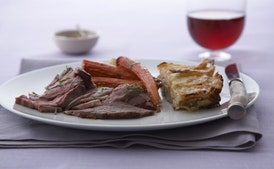

### Sun-Dried Tomato and Garlic-Crusted Rack of Lamb

**List of Ingredients:**
- 2 6- to 7-ounce jars oil-packed sun-dried tomatoes with herbs, drained well, oil reserved
- 8 large garlic cloves, peeled
- 2 large shallots, peeled, halved
- 1 tablespoon dried oregano
- 3 tablespoons olive oil
- 4 garlic cloves, peeled
- 3 large fresh rosemary sprigs
- 2 2-pound racks of lamb (8 chops each), trimmed, frenched

**Preparation Instructions:**
1. Preheat oven to 350°F. Place 1/4 cup reserved tomato oil, garlic, and shallots in small baking dish; sprinkle with salt and pepper and cover with foil. Bake until garlic is tender, about 45 minutes.
2. Transfer garlic mixture to processor. Add tomatoes and oregano. Blend until paste forms. Season with salt and pepper.
3. Heat oil in heavy large skillet over medium-high heat. Add garlic and rosemary to skillet. Saute until garlic browns, about 5 minutes. Discard garlic and rosemary.
4. Sprinkle lamb on all sides with salt and pepper. Add 1 rack to sk

None

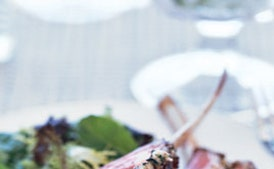

In [18]:
answer_processing(answer)

# Pruebas

In [172]:
# prompt = f"""
# Context information is below.
# ---------------------
# {context}
# ---------------------
# {images}
# ---------------------
# Given the context information and not prior knowledge, answer the query, choose the correct image route from the directory paths 
# and write your answer in a markdown form.
# Be consistent, always write the image paths with this label **Image Path:**, and always split recepies with \n\n---\n\n
# Query: {query}
# Image path:
# Answer:
# """

# print(prompt)

In [ ]:
# answer = run_mistral(prompt)
# print(answer)

Here are some recipe preparations using the oven and lamb:

### Honey-Vinegar Leg of Lamb with Fennel and Carrots

**Ingredients:**
- 2 garlic cloves, chopped
- 1 cup fresh flat-leaf parsley leaves
- 1 tablespoon fennel seeds, crushed
- 1/2 cup fennel fronds plus more for serving
- 1/2 cup olive oil, divided
- Kosher salt, freshly ground pepper
- 1 7–9 pound bone-in leg of lamb, tied
- 1/2 cup red wine vinegar
- 1/3 cup honey
- 4 fennel bulbs, sliced 1/2" thick
- 16 small carrots (about 2 pounds), unpeeled, halved lengthwise if large

**Preparation Instructions:**
1. Pulse garlic, parsley, fennel seeds, and 1/2 cup fennel fronds in a food processor until very finely chopped.
2. With motor running, slowly add 1/4 cup oil and process until smooth; season generously with salt and pepper.
3. Rub parsley mixture all over lamb. Transfer to a roasting pan, cover, and chill at least 8 hours.
4. Let lamb sit at room temperature 1 hour. Bring vinegar and honey to a boil in a small saucepan. Redu

## Christmas Wreaths

### Ingredients
- 1/2 cup (4 ounces) unsalted butter
- 30 (7.25 ounces) large marshmallows
- 1 1/2 teaspoons green liquid food coloring
- 1 teaspoon pure vanilla extract
- 4 cups (5 ounces) cornflakes
- 2 tablespoons (1 ounce) cinnamon red-hots (candied)
- Equipment: flat counter or cookie sheet, lined with wax paper, sprayed with nonstick vegetable cooking spray or lightly greased or buttered; 2 small spoons sprayed with nonstick vegetable cooking spray or lightly greased or buttered.

### Preparation Instructions
1. Spray a medium saucepan with nonstick vegetable shortening or lightly grease it.
2. Melt the butter over low heat.
3. Add the marshmallows and melt them over low heat, stirring constantly, until smooth (about 6 minutes). Remove the pan from the heat and whisk in the food coloring and vanilla extract until well blended. Stir in the cornflakes to coat them well.
4. Keep the mixture warm by placing the saucepan in a large pot or skillet filled with 1 in

None

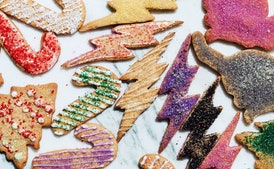

## Christmas Cake

### Ingredients
- 3 cups (450g) raisins
- 1 1⁄2 cups (240g) golden raisins
- 1 cup (160g) dried currants
- 8 soft fresh dates (160g), pitted and chopped
- 1 cup (140g) slivered almonds
- 3/4 cup (180ml) brandy
- 250g unsalted butter, softened
- 1 1/4 cups (220g) light brown sugar
- 4 eggs
- 2 1/4 cups (335g) plain (all-purpose) flour, sifted
- 1/4 teaspoon bicarbonate of (baking) soda
- 1 1/2 teaspoons ground cinnamon
- 1 teaspoon ground allspice
- 2–3 tablespoons brandy, extra

### Preparation Instructions
1. Place both raisins, currants, dates and almonds in a large bowl. Add the brandy, mix to combine and cover with plastic wrap. Allow to soak in a cool dark place overnight, mixing occasionally.
2. Preheat oven to 140°C (275°F). Line a 20cm (8-inch) square cake tin with 2 layers of non-stick baking paper.
3. Place the butter and sugar in the bowl of an electric mixer and beat on medium speed for 8 minutes or until pale and creamy. Add the eggs, 1 at a time, beatin

None

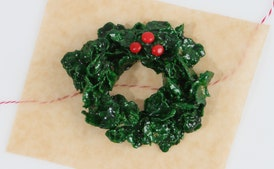

## Christmas Honey Fritters (Struffoli)

### Ingredients
- 3 1/2 cups all-purpose flour
- 5 large eggs
- 1 large egg yolk
- Grated zest of 2 lemons
- Juice of 1 lemon
- Grated zest of 1 orange
- 1/2 teaspoon salt
- 1 tablespoon limoncello or grand Marnier
- 4 cups extra-virgin olive oil, for deep-frying
- 2 cups honey
- Confectioners' sugar, for dusting

### Preparation Instructions
1. In a large bowl, combine the flour, eggs, yolk, half the lemon zest, the orange zest, salt, and limoncello. Stir with a wooden spoon to mix well, then knead into a firm dough, 8 to 10 minutes. Cover and allow to rest in the refrigerator for 30 minutes.
2. Cut the dough into golf ball-sized pieces. One at a time, roll each one into a 1/2-inch-thick rope, and cut into 1/2-inch-long pieces, and roll each piece into a ball. Place in a floured tray.
3. In a large deep pot, heat the oil to 375°F. Working in batches to avoid crowding the pan, fry the balls until dark golden brown, using a slotted spoon to turn 

None

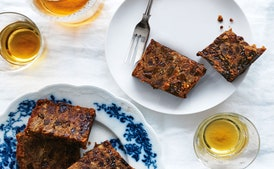